# SSP-MMC for FSRS

SSP-MMC stands for "Stochastic-Shortest-Path-Minimize-Memorization-Cost". It is a reinforcement learning algorithm that is designed to minimize the cost of memorization in the context of spaced repetition. This is a re-implementation of the original SSP-MMC algorithm in Numpy. The memory model is updated to FSRS instead of DHP-HLR.

Original code: https://github.com/maimemo/SSP-MMC

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt

s_size = 10000
s_min = 0.01
s_max = 3650

d_size = 90
d_min = 1
d_max = 10

r_size = 30
r_min = 0.7
r_max = 0.99

s_state = np.linspace(s_min, s_max, s_size)
d_state = np.linspace(d_min, d_max, d_size)
r_state = np.linspace(r_min, r_max, r_size)

s_state_mesh, d_state_mesh, r_state_mesh = np.meshgrid(
    s_state, d_state, r_state)

cost_matrix = np.zeros((d_size, s_size))
cost_matrix.fill(1000)
cost_matrix[:, -1] = 0
action_matrix = np.zeros((d_size, s_size))

w = [
    0.5701, 1.4436, 4.1386, 10.9355,
    5.1377, 1.225, 0.8735, 0.0375,
    1.647, 0.1361, 1.0293,
    2.1111, 0.0864, 0.323, 1.4188,
    0.219, 2.8467
]


def stability_after_success(s, d, r):
    return np.maximum(
        s_min,
        s
        * (
            1
            + np.exp(w[8])
            * (11 - d)
            * np.power(s, -w[9])
            * (np.exp((1 - r) * w[10]) - 1)
        ),
    )


def stability_after_failure(s, d, r):
    return np.maximum(
        s_min,
        np.minimum(
            w[11]
            * np.power(d, -w[12])
            * (np.power(s + 1, w[13]) - 1)
            * np.exp((1 - r) * w[14]),
            s,
        ),
    )


def mean_reversion(init, current):
    return (w[7] * init + (1 - w[7]) * current).clip(1, 10)


def difficulty_after_success(d):
    return mean_reversion(w[4], d)


def difficulty_after_failure(d):
    return mean_reversion(w[4], d + 2 * w[6])


# stability to index
def s2i(s): return np.clip(np.floor((s - s_min) /
                                    (s_max - s_min) * s_size).astype(int), 0, s_size - 1)
# difficulty to index


def d2i(d): return np.clip(np.floor((d - d_min) /
                                    (d_max - d_min) * d_size).astype(int), 0, d_size - 1)
# retention to index


def r2i(r): return np.clip(np.floor((r - r_min) /
                                    (r_max - r_min) * r_size).astype(int), 0, r_size - 1)


# indexes to cost
def i2c(s, d): return cost_matrix[d2i(d), np.maximum(
    s2i(s), s2i(s_state_mesh) + 1).clip(0, s_size - 1)]

In [2]:
i = 0
diff = 10000
n_iter = 1000

success_cost = 3
failure_cost = 9

start = time.time()

while i < n_iter and diff > 1e-6 * s_size * d_size:
    next_stability_after_success = stability_after_success(
        s_state_mesh, d_state_mesh, r_state_mesh
    )
    next_difficulty_after_success = difficulty_after_success(d_state_mesh)
    next_cost_after_success = (
        i2c(next_stability_after_success,
            next_difficulty_after_success) + success_cost
    )

    next_stability_after_failure = stability_after_failure(
        s_state_mesh, d_state_mesh, r_state_mesh
    )
    next_difficulty_after_failure = difficulty_after_failure(d_state_mesh)
    next_cost_after_failure = (
        i2c(next_stability_after_failure,
            next_difficulty_after_failure) + failure_cost
    )

    expected_cost = (
        r_state_mesh * next_cost_after_success
        + (1 - r_state_mesh) * next_cost_after_failure
    )
    # update cost matrix
    optimal_cost = np.minimum(cost_matrix, expected_cost.min(axis=2))
    action_matrix = r_state[np.argmin(expected_cost, axis=2)]
    diff = cost_matrix.sum() - optimal_cost.sum()
    cost_matrix = optimal_cost
    if i % 10 == 0:
        print(
            f"iteration {i:>5}, diff {diff:.2f}, time {time.time() - start:.2f}s")
    i += 1

end = time.time()
print(f"Time: {end - start:.2f}s")
avg_cost = cost_matrix.mean()
print(f"Average cost: {avg_cost:.2f}")
avg_retention = action_matrix.mean()
print(f"Average retention: {avg_retention:.2f}")

iteration     0, diff 620675413.76, time 2.16s
iteration    10, diff 1041139.62, time 23.14s
iteration    20, diff 4715.25, time 44.39s
iteration    30, diff 2.34, time 65.78s
Time: 70.00s
Average cost: 6.65
Average retention: 0.89


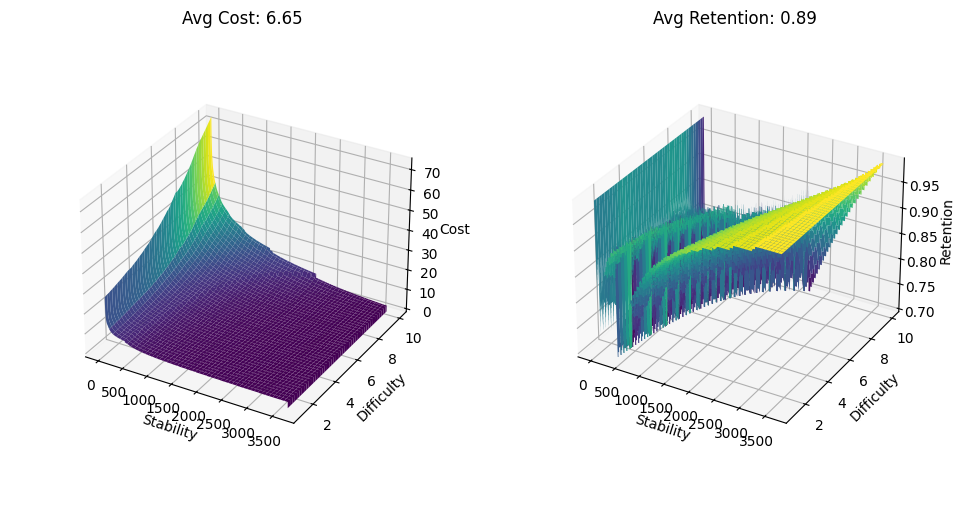

In [3]:
s_state_mesh, d_state_mesh = np.meshgrid(s_state, d_state)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(121, projection="3d")
ax.plot_surface(s_state_mesh, d_state_mesh, cost_matrix, cmap="viridis")
ax.set_xlabel("Stability")
ax.set_ylabel("Difficulty")
ax.set_zlabel("Cost")
ax.set_title(f"Avg Cost: {avg_cost:.2f}")
ax.set_box_aspect(None, zoom=0.8)
ax = fig.add_subplot(122, projection="3d")
ax.plot_surface(s_state_mesh, d_state_mesh, action_matrix, cmap="viridis")
ax.set_xlabel("Stability")
ax.set_ylabel("Difficulty")
ax.set_zlabel("Retention")
ax.set_title(f"Avg Retention: {avg_retention:.2f}")
ax.set_box_aspect(None, zoom=0.8)
plt.tight_layout()
plt.show()

Retention: 70.00%
Time: 1.77s


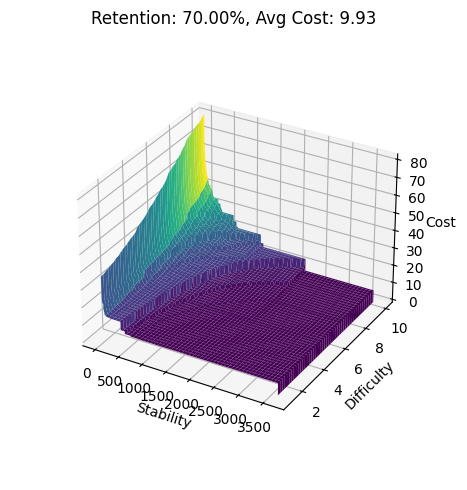

Retention: 73.22%
Time: 1.89s


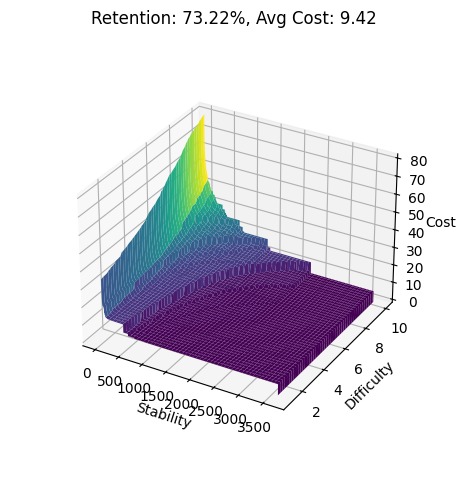

Retention: 76.44%
Time: 1.76s


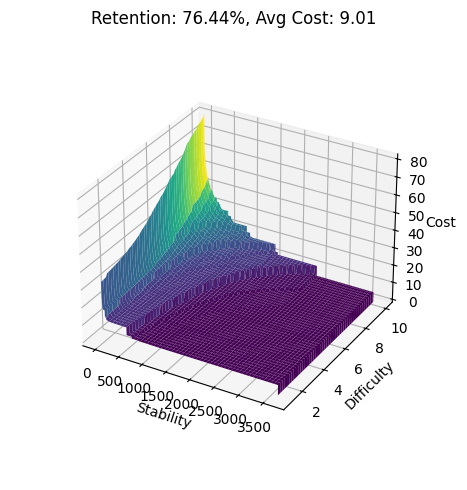

Retention: 79.67%
Time: 1.81s


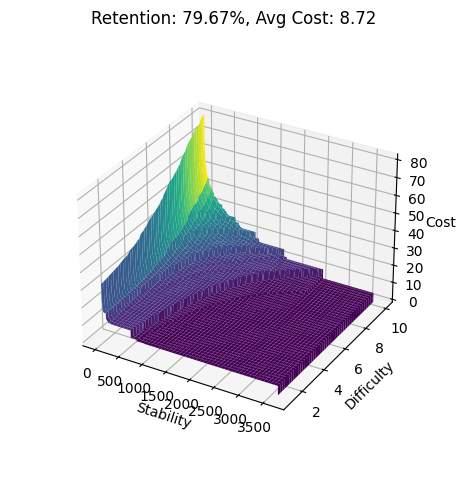

Retention: 82.89%
Time: 1.93s


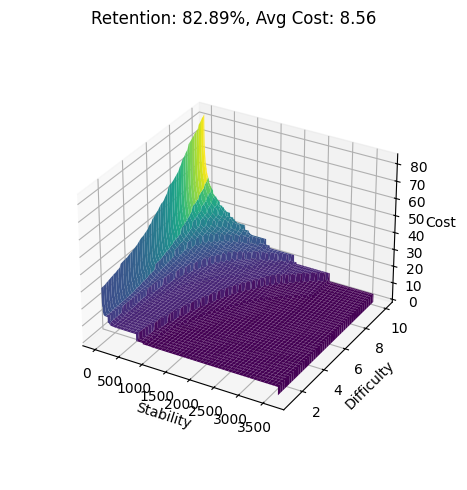

Retention: 86.11%
Time: 1.94s


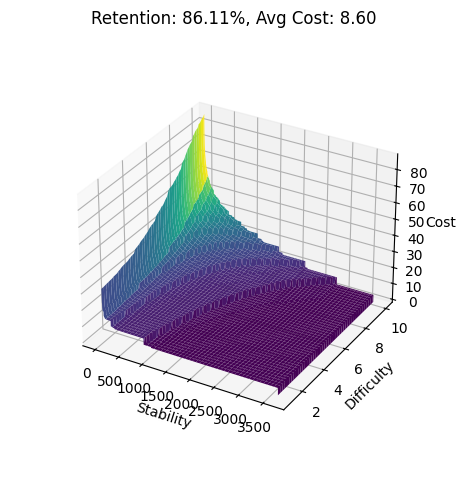

Retention: 89.33%
Time: 2.24s


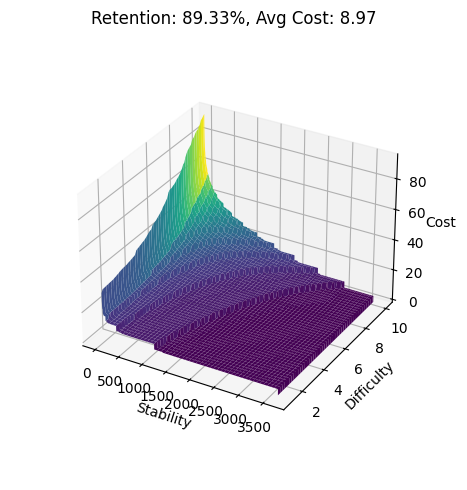

Retention: 92.56%
Time: 2.55s


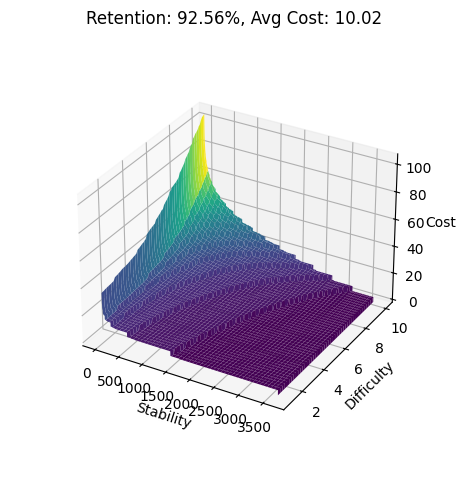

Retention: 95.78%
Time: 3.57s


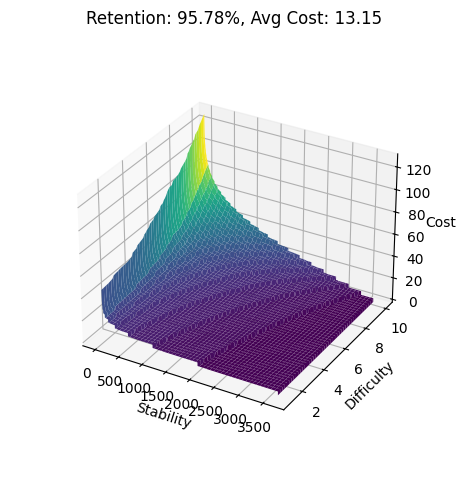

Retention: 99.00%
Time: 6.87s


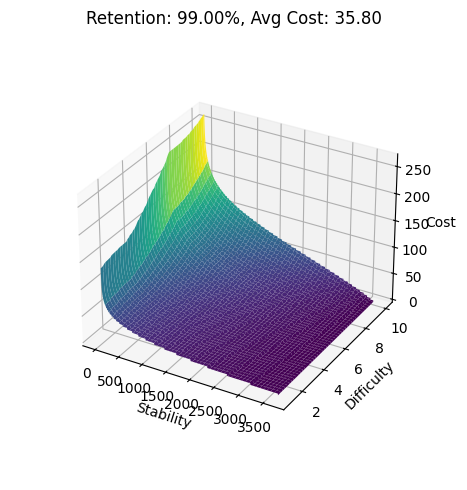

In [4]:
success_cost = 3
failure_cost = 9

for r in np.linspace(0.7, 0.99, 10):
    start = time.time()
    print(f"Retention: {r * 100:.2f}%")
    cost_matrix = np.zeros((d_size, s_size))
    cost_matrix.fill(1000)
    cost_matrix[:, -1] = 0
    s_state_mesh, d_state_mesh = np.meshgrid(s_state, d_state)
    r_state_mesh = r * np.ones((d_size, s_size))

    i = 0
    diff = 10000
    n_iter = 1000
    while i < n_iter and diff > 1e-6 * s_size * d_size:
        next_stability_after_success = stability_after_success(
            s_state_mesh, d_state_mesh, r_state_mesh
        )
        next_difficulty_after_success = difficulty_after_success(d_state_mesh)
        next_cost_after_success = (
            i2c(next_stability_after_success, next_difficulty_after_success)
            + success_cost
        )

        next_stability_after_failure = stability_after_failure(
            s_state_mesh, d_state_mesh, r_state_mesh
        )
        next_difficulty_after_failure = difficulty_after_failure(d_state_mesh)
        next_cost_after_failure = (
            i2c(next_stability_after_failure, next_difficulty_after_failure)
            + failure_cost
        )

        expected_cost = (
            r_state_mesh * next_cost_after_success
            + (1 - r_state_mesh) * next_cost_after_failure
        )
        # update cost matrix
        optimal_cost = np.minimum(cost_matrix, expected_cost)
        diff = cost_matrix.sum() - optimal_cost.sum()
        cost_matrix = optimal_cost
        i += 1
    end = time.time()
    print(f"Time: {end - start:.2f}s")
    avg_cost = cost_matrix.mean()
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(111, projection="3d")
    ax.plot_surface(s_state_mesh, d_state_mesh, cost_matrix, cmap="viridis")
    ax.set_xlabel("Stability")
    ax.set_ylabel("Difficulty")
    ax.set_zlabel("Cost")
    ax.set_title(f"Retention: {r * 100:.2f}%, Avg Cost: {avg_cost:.2f}")
    ax.set_box_aspect(None, zoom=0.8)
    plt.tight_layout()
    plt.show()